## Exercise 2: Feature Engineering & Exploratory Data Analysis (EDA) 

### Part 2 - Feature engineering

In [124]:
import pandas as pd
import json
import psycopg2
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
from datetime import datetime


##### 1. Load postgreSQL credentials from config file and load data

In [125]:
with open("../config.json", "r") as f:
    config = json.load(f)

    db_name = config["DB_NAME"]
    db_user = config["DB_USER"]
    db_password = config["DB_PASSWORD"]
    db_host = config["DB_HOST"]
    db_port = int(config["DB_PORT"])

DB_URL = f"postgresql://{db_user}:{db_password}@{db_host}:{db_port}/{db_name}"
engine = create_engine(DB_URL)

customers = pd.read_sql("SELECT * FROM customers", con=engine)
policies = pd.read_sql("SELECT * FROM policies", con=engine)
claims = pd.read_sql("SELECT * FROM claims", con=engine)
risk_indicators = pd.read_sql("SELECT * FROM risk_indicators", con=engine)
print("Data read from DB!")

Data read from DB!


#### 1. Analyze number of claims per customer

In [126]:
policies_per_customer = policies['customer_id'].value_counts().reset_index(name='num_pol')
claims_per_customer = claims['customer_id'].value_counts().reset_index(name='num_claims')

# Left join both tables
claims_merged = pd.merge(claims_per_customer, policies_per_customer, on='customer_id', how='left')

# Average column
claims_merged['average'] = (claims_merged['num_claims'] / claims_merged['num_pol']).round(1)

# Group by average column
claims_merged_counted = claims_merged.groupby('average').size().reset_index(name='Count')

# Adding customers that made 0 claims
claims_merged_counted.loc[-1] = [0, len(customers) - claims_merged_counted['Count'].sum()]

claims_merged_counted.index = claims_merged_counted.index + 1  # shifting index
claims_merged_counted.sort_index(inplace=True)  # sorting by index

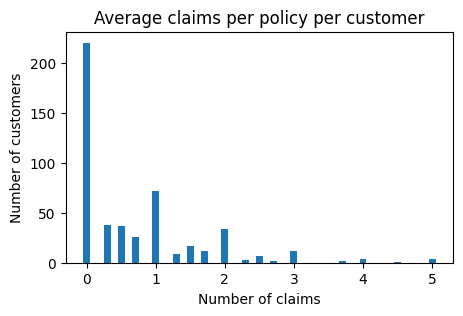

In [127]:
# Plotting
plt.figure(figsize=(5, 3))
plt.bar(claims_merged_counted['average'], claims_merged_counted['Count'],width=0.1)
plt.title('Average claims per policy per customer')
plt.xlabel('Number of claims')
plt.ylabel('Number of customers')
plt.show()

As it was seen in part 1, there are far more customers with 0 claim than with 1 or more. This is even amplified when averaging the amount of claims per number of policies. Since bar for 0 customers is too high, we can remove it and plot a histogram and density chart with only reported claims.

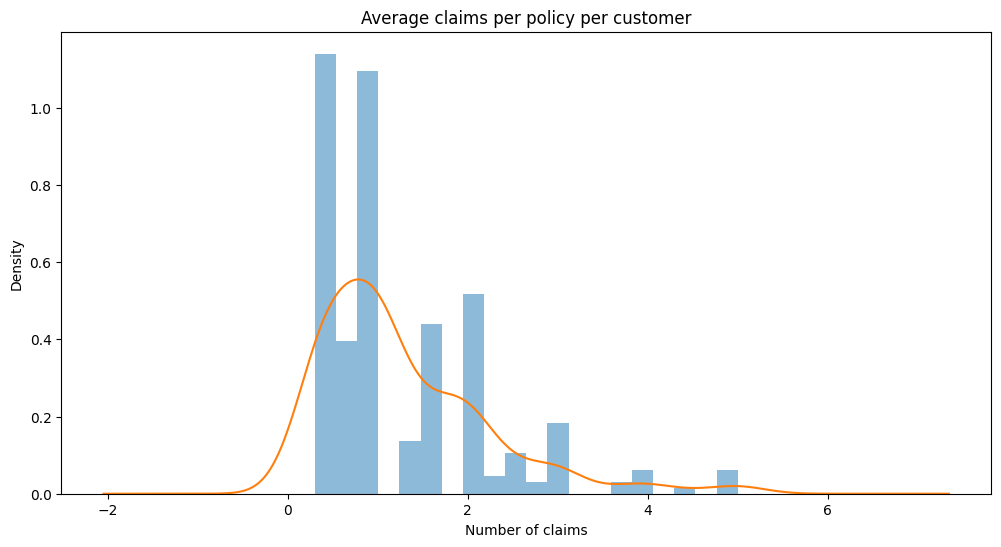

In [128]:
ax = claims_merged['average'].plot(kind='hist', bins=20, density=True, alpha=0.5,
figsize=(12, 6))
claims_merged['average'].plot(kind='kde', ax=ax)
plt.title('Average claims per policy per customer')
plt.xlabel('Number of claims')
plt.show()


Average claim per each policy has a peak around 1. 

#### 2. Analyze customers behavior regarding claims  

##### Time from policy creation until claim report

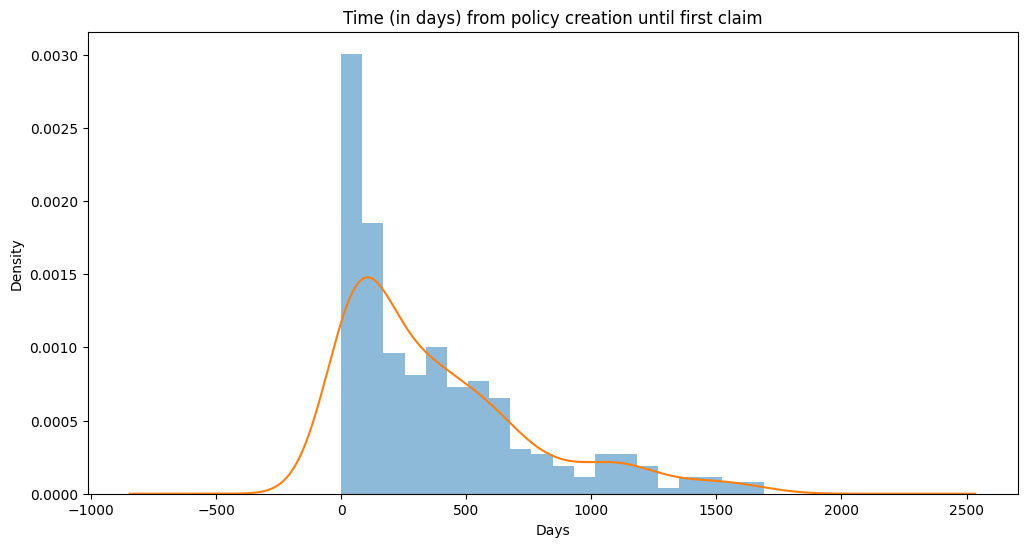

In [129]:
# Removing those with missing date (2020-01-01 by default)
policies_filtered = policies[policies['created_at'] != '2020-01-01']
claims_filtered = claims[claims['claim_date'] != '2020-01-01']

# Find the earliest claim for each policy
earliest_dates = claims_filtered.loc[claims_filtered.groupby('policy_id')['claim_date'].idxmin()]

# Left join both tables
claims_merged_policies = pd.merge(earliest_dates, policies_filtered[['policy_id','created_at']], on='policy_id', how='left')

# Find how many days since policy creation until claim report
claims_merged_policies['time_difference_days'] = (claims_merged_policies['claim_date'] - claims_merged_policies['created_at']).dt.days

# Plot histogram
ax = claims_merged_policies['time_difference_days'].plot(kind='hist', bins=20, density=True, alpha=0.5,
figsize=(12, 6))
claims_merged_policies['time_difference_days'].plot(kind='kde', ax=ax)

plt.title('Time (in days) from policy creation until first claim')
plt.xlabel('Days')
plt.show()

There are many around 0 but that is because the claim dates use the policy data as reference when generating the data.

##### Time between 2 claims from same customer

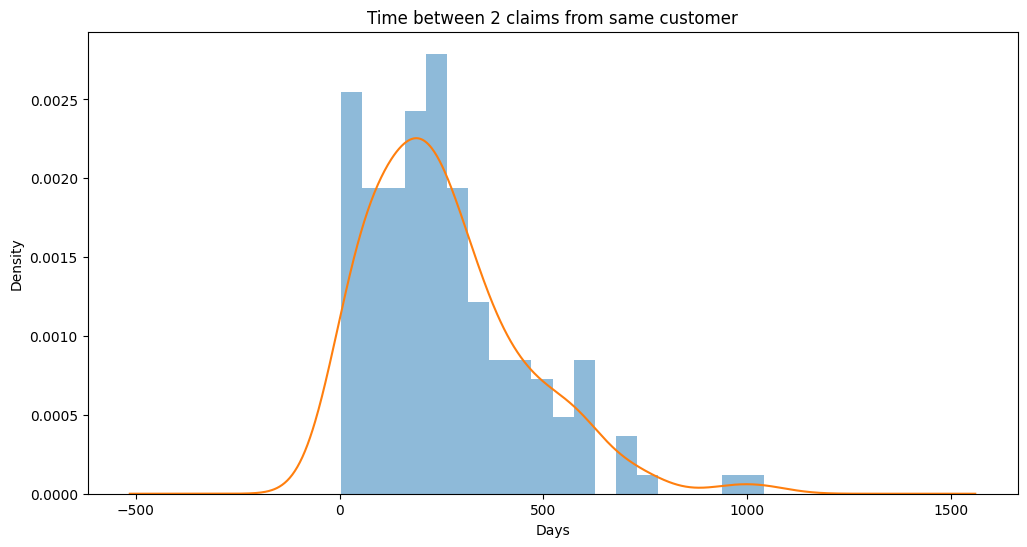

In [130]:
# Removing claims with missing date (2020-01-01 by default) & counting claims per client
claims_per_customer_filtered = claims_filtered['customer_id'].value_counts().reset_index(name='num_claims')

# Find customers that have reported more than 1 claim
customers_multi_claim = claims_per_customer_filtered[claims_per_customer_filtered['num_claims'] > 1]['customer_id']

# Find claims of those customers
multi_claims = claims_filtered[claims_filtered['customer_id'].isin(customers_multi_claim)].sort_values(by=["customer_id","claim_date"])

# Calculate average time
time_between_claims_per_customer = multi_claims.groupby('customer_id')['claim_date'].apply(lambda x: x.diff().mean().days).reset_index(name='time_elapsed')

# Plot histogram
ax = time_between_claims_per_customer['time_elapsed'].plot(kind='hist', bins=20, density=True, alpha=0.5,
figsize=(12, 6))
time_between_claims_per_customer['time_elapsed'].plot(kind='kde', ax=ax)

plt.title('Time between 2 claims from same customer')
plt.xlabel('Days')
plt.show()

Another interesting metric is to see how much time does it take for a customer to report another claim since the first one is reported. This is what this graph shows, with a maximum peak on about 300 days, or 1 year. So the suggestion for the insurance company is to investigate if the expected amount of money received by a customer during a year is higher than the average price of a claim resolution.

#### 3. Correlation between risk and previous features

##### Claim amount per customer vs risk

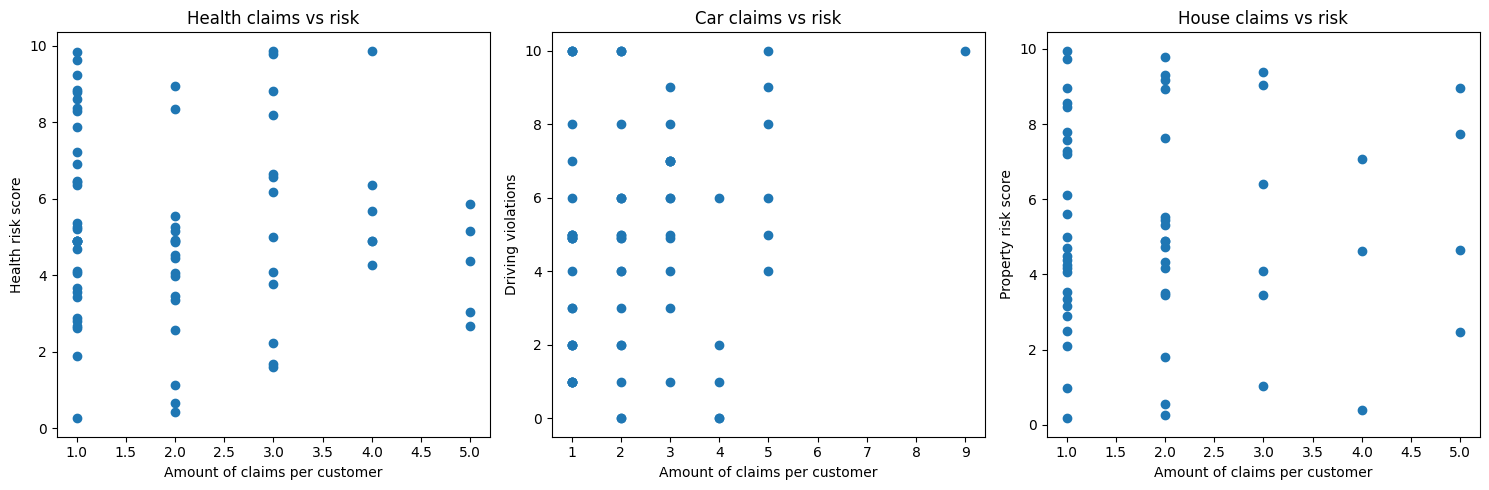

In [131]:
# Left join claim table with policy types and group by cust_id + type
claims_types_count = pd.merge(claims, policies[['policy_id','policy_type']], on='policy_id', how='left').groupby(by=["customer_id","policy_type"]).size().reset_index(name='Count')

# Split claims per policy type
claims_health_count = claims_types_count[claims_types_count['policy_type'] == 'health']
claims_car_count = claims_types_count[claims_types_count['policy_type'] == 'car']
claims_house_count = claims_types_count[claims_types_count['policy_type'] == 'house']

# Join each list with risk factor by consumer_id
claims_health_risk_count = pd.merge(claims_health_count, risk_indicators[['customer_id','health_risk_score']], on='customer_id', how='left')
claims_car_risk_count = pd.merge(claims_car_count, risk_indicators[['customer_id','driving_violations']], on='customer_id', how='left')
claims_house_risk_count = pd.merge(claims_house_count, risk_indicators[['customer_id','property_risk_score']], on='customer_id', how='left')

# Create a figure with 3 subplots horizontally
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))

ax1.scatter(claims_health_risk_count['Count'], claims_health_risk_count['health_risk_score'])
ax1.set_title('Health claims vs risk')
ax1.set_xlabel('Amount of claims per customer')
ax1.set_ylabel('Health risk score')

ax2.scatter(claims_car_risk_count['Count'], claims_car_risk_count['driving_violations'])
ax2.set_title('Car claims vs risk')
ax2.set_xlabel('Amount of claims per customer')
ax2.set_ylabel('Driving violations')

ax3.scatter(claims_house_risk_count['Count'], claims_house_risk_count['property_risk_score'])
ax3.set_title('House claims vs risk')
ax3.set_xlabel('Amount of claims per customer')
ax3.set_ylabel('Property risk score')
plt.tight_layout()
plt.show()



There is no relation because of the data being randomly generated